# Osnove Pythona

## Objekti i njihova imena

Osnovna razlika Pythona od jezika poput C-a je: U C-u, memorijske lokacije su primarni objekti kojima baratamo; vrijednosti zapisane u njima su sekundarne. Varijable su zato uvijek imena za "kutije": nizove od nekoliko (fiksno i konačno mnogo) uzastopnih memorijskih lokacija, unutar kojih se nalazi vrijednost objekta. Čak i kod dinamički alocirane memorije, deklarirane varijable uvijek imaju fiksnu i ograničenu veličinu (`sizeof`), dok o našoj interpretaciji njihovog sadržaja kao pointera ovisi naša sposobnost da spremimo potencijalno više podataka u memoriju nego što smo statički alocirali.

U Pythonu, pogled na svijet je bitno drugačiji: primarne "vrijednosti" kojima baratamo su upravo objekti; memorijske lokacije su potpuno irelevantne, a da bismo došli do objekata odnosno da bismo ih mogli spomenuti u kodu, dajemo im _imena_. `x = 382` ne znači (kao u C-u) "stvori kutiju imena `x` i u nju stavi bit-pattern `0...0101111110` koji će se interpretirati kao `int`", već "stvori objekt `382` (klase `int`), i daj mu ime `x`".

Direktna posljedica: tip više nije svojstvo varijable (imena), nego objekta. `x = 3; x = 'tri'` je sasvim legalno. Naravno, hoće li `x.islower()` dignuti `AttributeError` ili vratiti `True`, ovisi o konkretnoj vrijednosti od `x` u trenutku poziva -- baš kao da smo napisali `3 .islower()` odnosno `'tri'.islower()`. Još jedna posljedica: isti objekt može imati više imena. `x = y` jednostavno uzme objekt imena `y`, i dade mu još jedno ime `x`. Pridruživanjem imena se _ništa nikamo ne kopira._ Na primjer kod poziva funkcije, objekti koje smo naveli kao funkcijske argumente jednostavno dobiju još neka _lokalna_ imena, koja zovemo parametrima. Opet, ništa se nikamo ne kopira.

Da bismo ustanovili odnose li se imena `x` i `y` na isti objekt, možemo pitati `x is y`. Napomena: to nema veze s jednakošću, koja se testira s `x == y`. Implementacija jednakosti, kao i mnogih drugih operatora/metoda, ovisi o tipu od `x` (i možda od `y`): npr. razlomci bitno drugačije definiraju jednakost nego IP-adrese. Čak i da dva objekta imaju potpuno istu reprezentaciju u memoriji (tada će vjerojatno biti `x == y`), to i dalje mogu biti dva objekta (`x is not y`), i promjena jednog neće utjecati na drugi objekt. Druga implikacija (`x is y` povlači `x == y`, odnosno zapravo `x == x`) vrijedi puno češće, i jedini standardni kontraprimjer je NaN (`math.nan`).

In [1]:
from math import nan
{1: nan == nan, 2: nan is nan, 3: [] == [], 4: [] is []}

{1: False, 2: True, 3: True, 4: False}

### Prostori imenâ (*namespaces*)

Kako su imena očito vrlo važna i zapravo jedini način da u kodu govorimo o objektima, Python posvećuje posebnu pažnju njihovom razvrstavanju. Svako ime postoji u točno jednom **prostoru**, te se prostori imena dijele na implicitne (čija imena se obično ne navode) i eksplicitne (čija imena se moraju navesti).

Implicitnih prostora imena ima četiri vrste, i uvijek su ugniježđeni na isti način. Vanjski je `builtins`, u kojem žive preddefinirana imena za Pythonove ugrađene funkcije i ostale objekte (npr. `print`). Obično se ne mijenja, iako Python dopušta i njegovu promjenu.

Sljedeći prema unutra je `globals`, u kojem žive ili varijable koje smo definirali unutar interaktivnog rada (npr. pisanja u Jupyterovoj bilježnici), ili pak "globalne" varijable pojedinog _modula_ (ugrubo, datoteke s nastavkom `.py`) koje nisu ni u kojem unutrašnjem (klasnom ili lokalnom) prostoru. U njega možemo slobodno dodavati imena, a možemo i mijenjati njihove vrijednosti -- ali to se ne smatra dobrom praksom iz svih uobičajenih razloga protiv globalnih varijabli (globalne *konstante*, imena čije se vrijednosti ne mijenjaju -- npr. funkcije i klase koje modul definira -- su sasvim u redu).

Unutar `globals` postoje dvije vrste prostora imena, koji se oba zovu `locals` ali ne vide jedan drugog bez obzira na sintaksnu ugniježđenost: klasni i funkcijski. U klasnom prostoru žive atributi (uključujući metode i svojstva) klase unutar koje se nalazimo (ako se uopće nalazimo unutar bloka `class `...`:`). Točna priroda ovog bloka, pa tako i mogućnost mijenjanja, ovisi o tipu trenutne klase (tzv. "metaklasi"), no često se u njemu nalaze samo metode.

U funkcijskom lokalnom prostoru žive "prave" lokalne varijable (uključivo parametri) funkcije unutar koje se nalazimo (ako se uopće nalazimo unutar bloka `def `...`:`). U ovom prostoru imena su fiksna (samo ona koja se sintaksno pojavljuju u kodu funkcije) i nije moguće dodavati nova imena dinamički, iako je naravno moguće mijenjati njihove vrijednosti. Ovaj prostor imena iznova se stvara svakim pozivom funkcije, i prestaje postojati povratkom iz funkcije; zato je posebno optimiziran. Funkcijski lokalni prostori mogu biti i međusobno ugniježđeni, ako imamo jednu funkciju definiranu unutar druge.

Za implicitne prostore imena vrijedi jednostavno pravilo: _čitanje_ vrijednosti imena (npr. korištenje imena u nekom izrazu) obavlja se prvo u trenutnom prostoru, te ako ga tamo nema, u prvom iznad, te ako ga ni tamo nema, u sljedećem iznad njega... i tako dalje u hijerarhiji. Ako se ime ne nađe ni u jednom implicitnom prostoru imena (čak niti u `builtins`), prijavljuje se greška `NameError`. S druge strane, _postavljanje_ vrijednosti imena (npr. pridruživanje tog imena nekom objektu), kao i _brisanje_ vrijednosti imena (npr. naredbom `del`), _uvijek_ se obavlja u trenutnom prostoru imena (osim ako smo to promijenili direktivom `global` ili `nonlocal`).

Eksplicitni prostori imena su puno jednostavniji, i ima ih dva tipa: atributni (oni čija imena se navode kao `prostor.ime`) i spremnički (oni čija imena se navode kao `prostor[ime]`). Atributni su vrlo slični implicitnima, samo su vezani uz _objekte_ (instance) pojedinih klasa. Gotovo svaki objekt u Pythonu ima svoj atributni prostor imena. Važan specijalni slučaj: `import nekimodul` stvara objekt imena `nekimodul`, čiji atributni prostor je upravo globalni prostor modula `nekimodul.py`. Na taj način možemo jednostavno koristiti globalna imena iz jednog modula u drugom. Atributni prostori su često dinamički (možemo dodavati i brisati imena), iako pomoću definicije imena `__slots__` možemo fiksirati skup imena (vrlo slično funkcijskom lokalnom prostoru).

Spremnički prostor imena imaju samo posebni tipovi *spremnici*, kao što su npr. liste i rječnici. Njihova posebnost je u tome da "imena" u njima mogu biti proizvoljni objekti (najčešće se ipak zahtijeva da budu nepromjenjivi) — u svim ostalim prostorima, imena moraju biti validni identifikatori: nizovi znakova koji sadrže samo slova, znamenke i znak `_`, a ne počinju znamenkom. U slučaju listi (i raznih drugih sekvenci kao što su slogovi, stringovi, polja,...), validna imena su cijeli brojevi i zovu se *indeksi*. U slučaju rječnika, validna imena su bilo kakvi _hashabilni_ objekti i zovu se *ključevi*.

### Primjena: uvoz modula

Recimo da imamo modul `m.py`, unutar kojeg se nalazi kod
```py
x = y = 2
z = 3
```

Naredbom `import m` dobit ćemo (u trenutnom prostoru imena) ime `m` koje će se odnositi na objekt tipa `module`, čiji atributni prostor imena će imati tri imena: `m.x` i `m.y` će biti imena za jedan te isti broj `2`, dok će `m.z` biti ime za broj `3`. Naredbom `import m as n` dobit ćemo ime `n` koje će se odnositi na isti objekt opisan gore. Tako će `n.x` i `n.y` biti imena za `2`, dok će `n.z` biti ime za `3`. Ovo najčešće koristimo kad želimo skratiti ime modula, posebno kad je modul u paketu te je time njegovo ime zapravo cijela "staza": `import matplotlib.pyplot as plt`.

Naredbom `from m import x` dobit ćemo (u trenutnom prostoru imena) ime `x` koje će se odnositi na broj `2`. Naredbom `from m import x as z` dobit ćemo ime `z` koje će se odnositi na broj `2`. Naredbom `from m import x, z` dobit ćemo imena `x` i `z` koja će se odnositi redom na `2` i `3`. Ovo koristimo kad imamo module koji sadrže sve i svašta, i treba nam samo uzak dio njihovih funkcionalnosti: `from functools import partial`. Također je korisno kad je glavnina funkcionalnosti modula u jednoj funkciji/klasi koja se zove jednako kao modul: `from datetime import datetime`.

Naredbom `from m import *` dobit ćemo imena `x`, `y` i `z`, takva da će se prva dva odnositi na broj `2`, a treće na broj `3`. Primijetite da se ovakav oblik naredbe ne može naći unutar funkcijske definicije, jer se time imena `x`, `y` i `z` ne bi nalazila sintaksno u tekstu funkcijske definicije, te Python ne bi mogao konstruirati lokalni funkcijski prostor imena (ne zna koja će se imena pojaviti u lokalnom prostoru sve do trenutka poziva funkcije). Također, loša strana ovog je teže razumijevanje koda: posebno pri _debuggiranju_, izuzetno je važno za svako ime znati iz kojeg prostora dolazi. Ako imamo

```py
from a import *
from b import *
from c import *
...  # puno uvezenih modula
... z ...
```

nemamo nikakav način da saznamo iz kojeg modula je `z`, te najčešće moramo istraživati jedan po jedan. Ipak, u interaktivnom _quick&dirty_ kodiranju često je vrlo praktično koristiti ovaj oblik.

### Primjena: prijenos argumenata u funkciju

In [2]:
def f(x):
    x = 8
    print(x)
x = 3
f(x)
print(x)

8
3


Ime `x` u prve tri linije različito je od imena `x` u druge tri linije: prvo živi u lokalnom funkcijskom prostoru funkcije `f`, dok drugo živi u globalnom prostoru ove bilježnice.

Prvo se definira funkcija `f`, s jednim lokalnim imenom `x`, koje je prvo (jednom kad se funkcija pozove) ime za argument funkcije, nakon toga ime za broj `8`, i nakon toga se njegova vrijednost (dakle `8`) prenese u funkciju `print` (precizno, funkciju čije ime u prostoru `builtins` je `print`).

Nakon toga stvorimo broj `3`, damo mu _globalno_ ime `x`, te s njime pozovemo funkciju `f` (precizno, funkciju čije ime u `globals` prostoru je `f`). Tada se stvori lokalni funkcijski prostor imena, u njemu ime `x` za broj `3`, zatim se to isto (lokalno) ime pridruži broju `8`, te se ispiše `8`. Time funkcija dolazi do kraja, njen lokalni prostor imena nestaje, te se izvršava sljedeća naredba nakon funkcijskog poziva, a to je ovaj `print(x)` u zadnjoj liniji. U tom trenutku, postoji samo jedan `x`, globalno ime `x` za objekt `3`, te se ispisuje `3`.

In [3]:
def g(x):
    x[2] = 8
    print(x)
x = [1, 5, 3]
g(x)
print(x)

[1, 5, 8]
[1, 5, 8]


Velika razlika od prethodnog primjera: također postoje dva imena, lokalni i globalni `x`, no ovaj put se oba cijelo vrijeme odnose na isti objekt: jednu jedinu listu u gornjem kodu. Naredba pridruživanja `x[2] = 8` ne mijenja lokalni funkcijski prostor funkcije `g` (u kojem živi `x`), već `x`ov spremnički prostor imena. Zapravo, to nije pridruživanje ničega imenu `x`, već je to pridruživanje (broja `8`) "imenu" (indeksu) `2` unutar prostora imena koji odgovara objektu (spremniku) `x`. To se najbolje može vidjeti po tome da u ovoj drugoj naredbi "x" može biti izraz: `(x if 2 < 3 else y)[2] = 8`, dok je naravno pridruživanje `(x if 2 < 3 else y) = 8` besmisleno.

### Za detaljniji prikaz ...

Izuzetno koristan alat za vizualizaciju Pythonove memorije nalazi se na http://pythontutor.com/visualize.html#mode=edit. Preporučujem provesti neko vrijeme igrajući se s njim, izvršavajući razne naredbe i gledajući kako Python reprezentira memoriju.

In [4]:
%%HTML
<iframe width="800" height="500" frameborder="0" src="http://pythontutor.com/iframe-embed.html#code=def%20f%28x%29%3A%0A%20%20%20%20x%20%3D%208%0A%20%20%20%20print%28x%29%0Ax%20%3D%203%0Af%28x%29%0Aprint%28x%29%0A%0Adef%20g%28x%29%3A%0A%20%20%20%20x%5B2%5D%20%3D%208%0A%20%20%20%20print%28x%29%0Ax%20%3D%20%5B1,%205,%203%5D%0Ag%28x%29%0Aprint%28x%29&codeDivHeight=400&codeDivWidth=350&cumulative=false&curInstr=0&heapPrimitives=true&origin=opt-frontend.js&py=3&rawInputLstJSON=%5B%5D&textReferences=false"> </iframe>

## Matematičke operacije

Python podržava rad s cijelim (`int`) i realnim (`float`) brojevima. `float` odgovara C-ovom tipu `double` (standard IEEE754 za prikaz realnih brojeva u računalu), dok je `int` sličan (niz bitova u dvojnom komplementu), jedino što nije ograničene veličine. Osnovne računske operacije pišu se jednako kao u jeziku C, osim što dijeljenje `int`ova proizvodi `float`.

In [5]:
68 + 27, 68 - 27, 68 * 27, 68 / 27

(95, 41, 1836, 2.5185185185185186)

Cjelobrojno dijeljenje (najveće cijelo kvocijenta) piše se `//`. Ostatak je `%` kao i u jeziku C. Često trebamo i jedno i drugo, to nam daje funkcija `divmod`.

In [6]:
68 // 27, 68 % 27, divmod(68, 27) 

(2, 14, (2, 14))

Za potenciranje možemo koristiti operator `**` ili funkciju `pow` kao u C-u. `pow(a,b,c)` računa $a^b\bmod c$, ali puno brže nego da stvarno potencira i dijeli.

In [7]:
68 ** 27, pow(68, 27), pow(68, 1_000_000, 27)

(30042816356321847106973754380840451238772376338432,
 30042816356321847106973754380840451238772376338432,
 13)

Rad s razlomcima, decimalnim brojevima proizvoljne preciznosti, kompleksnim brojevima, ...

In [8]:
from fractions import Fraction as F
from decimal import Decimal as D, getcontext
import cmath

Razlomljeni dio od $(\frac{18}{7})^2$... Prikažimo ga kao string, dohvatimo brojnik i nazivnik (sjetimo se, `_` je posljednji rezultat):

In [9]:
F(68, 27)**2 % 1

Fraction(250, 729)

In [10]:
str(_), _.numerator, _.denominator

('250/729', 250, 729)

Da bismo radili s decimalnim brojevima, moramo postaviti preciznost (broj znamenaka) s kojom ćemo računati neegzaktne decimalne brojeve kao $\frac13$.

Treba paziti na redoslijed operacija: ako prvo podijelimo `int`ove, dobit ćemo `float`, kojeg će `Decimal` egzaktno pretvoriti u (decimalno krivi) rezultat. Ako želimo doista decimalno dijeliti, moramo dijeliti decimalne brojeve.

In [11]:
getcontext().prec = 30
dict(krivo=D(18/7), točno=D(18)/D(7))

{'krivo': Decimal('2.571428571428571618895375650026835501194000244140625'),
 'točno': Decimal('2.57142857142857142857142857143')}

Decimalni brojevi imaju hrpu algoritama, recimo za računanje drugog korijena na proizvoljnu preciznost.

In [12]:
getcontext().prec = 200
D(2).sqrt()

Decimal('1.4142135623730950488016887242096980785696718753769480731766797379907324784621070388503875343276415727350138462309122970249248360558507372126441214970999358314132226659275055927557999505011527820605715')

In [13]:
_**2 - 2

Decimal('1E-199')

Potenciranje je desno asocirano, što omogućuje i jednostavno vađenje korijena ($\sqrt[3]{5}\approx\dots$). Također možemo računati i druge korijene, čak i negativnih brojeva. Kompleksni brojevi pišu se kao `(`x`+`y`j)`$, gdje su x i y realni i imaginarni dio redom.

In [14]:
{'treći_korijen iz pet': 5 ** 3**-1, 'drugi korijen iz sedam': 7 ** .5, 'približno i': (-1) ** .5}

{'treći_korijen iz pet': 1.7099759466766968,
 'drugi korijen iz sedam': 2.6457513110645907,
 'približno i': (6.123233995736766e-17+1j)}

Imaginarna jedinica je `1j`. Izvadimo joj realni i imaginarni dio, i usporedimo je sa zadnjom vrijednošću od `_`.

In [15]:
1j.real, 1j.imag, cmath.isclose(_['približno i'], 1j)

(0.0, 1.0, True)

U biblioteci [`cmath`](https://docs.python.org/3/library/cmath.html) nalaze se brojne transcendentne funkcije za rad s kompleksnim brojevima (u [`math`](https://docs.python.org/3/library/math.html) su više-manje iste funkcije za rad s realnim brojevima, kao u C-u).

In [16]:
(1 + 1j) ** 8, (7+9j)**12, cmath.isclose(1j**200, 1), cmath.cos(3+1j), cmath.log(-1)

((16+0j),
 (-378690592832-4811930855424j),
 True,
 (-1.5276382501165433-0.1658444019189788j),
 3.141592653589793j)

In [17]:
cmath.isclose(cmath.e ** (1j*cmath.pi) + 1, 0), cmath.isclose(cmath.e ** (1j*cmath.pi), -1)

(False, True)

Vidimo da pri radu s funkcijom `isclose` treba biti oprezan: uobičajeno njeno ponašanje je ocjena relativne greške, što je u većini slučajeva ono što želimo -- **osim kad uspoređujemo s nulom**. Tada moramo postaviti toleranciju apsolutne greške, inače će smatrati da je jedini broj blizu nule sama nula.

In [18]:
help(cmath.isclose)

Help on built-in function isclose in module cmath:

isclose(a, b, *, rel_tol=1e-09, abs_tol=0.0)
    Determine whether two complex numbers are close in value.
    
      rel_tol
        maximum difference for being considered "close", relative to the
        magnitude of the input values
      abs_tol
        maximum difference for being considered "close", regardless of the
        magnitude of the input values
    
    Return True if a is close in value to b, and False otherwise.
    
    For the values to be considered close, the difference between them must be
    smaller than at least one of the tolerances.
    
    -inf, inf and NaN behave similarly to the IEEE 754 Standard. That is, NaN is
    not close to anything, even itself. inf and -inf are only close to themselves.



In [19]:
cmath.isclose(cmath.e ** (1j * cmath.pi) + 1, 0, abs_tol=1e-9)

True

In [20]:
cmath.isclose(cmath.atan(cmath.inf), cmath.pi / 2)

True

Ako vam se više sviđa [$\tau$](https://tauday.com/tau-manifesto#sec-the_number_tau) od [$\pi$](http://www.thepimanifesto.com/), Python [ne bira strane](https://bugs.python.org/msg272457):

In [21]:
cmath.tau

6.283185307179586

## Spremnici

### Liste

Lista kao spremnički prostor imena, može (baš kao i drugi prostori imena) sadržavati vrijednosti različitih tipova.

In [22]:
lista = [3, -2, 5.8, 2j, 'bla', [3, 5], {8}, print, ZeroDivisionError]
lista

[3, -2, 5.8, 2j, 'bla', [3, 5], {8}, <function print>, ZeroDivisionError]

Duljina (broj elemenata spremnika) se u Pythonu dobije funkcijom `len`. Python podržava indeksiranje s početka i s kraja, negativnim brojevima. S lijevog kraja indeksiranje počinje s `0`, a s desnog s `-1 == ~0`, pa je prirodnije koristiti binarni komplement umjesto dvojnog.

In [23]:
len(lista), lista[3], lista[-2] is lista[len(lista)-2], lista[~2]

(9, 2j, True, {8})

Uzastopno indeksiranje, u slučaju da spremnici koriste druge spremnike. Stringovi su posebni: oni su nizovi znakova, ali znakovi nisu zasebni tip podataka već obični stringovi duljine 1 (kao što su prirodni brojevi nizovi znamenaka, ali znamenke nisu zasebni tip podataka već obični jednoznamenkasti brojevi).

In [24]:
lista[5][0], lista[4][2][0][0][0]

(3, 'a')

Rezanje liste od ili do nekog mjesta: prva tri elementa, svi nakon prva tri, zadnja tri, svi prije zadnja tri.

In [25]:
lista[:3], lista[3:], lista[-3:], lista[:-3]

([3, -2, 5.8],
 [2j, 'bla', [3, 5], {8}, <function print>, ZeroDivisionError],
 [{8}, <function print>, ZeroDivisionError],
 [3, -2, 5.8, 2j, 'bla', [3, 5]])

Rezanje liste između mjesta: intervali u Pythonu su uvijek **poluzatvoreni**. $[2..6\rangle=\{2,3,4,5\}$. Specijalno, $[7..7\rangle=\emptyset$.

In [26]:
lista[2:6], lista[1:-1], lista[7:7], lista[3:99]

([5.8, 2j, 'bla', [3, 5]],
 [-2, 5.8, 2j, 'bla', [3, 5], {8}, <function print>],
 [],
 [2j, 'bla', [3, 5], {8}, <function print>, ZeroDivisionError])

Preskakanje elemenata (u ovom slučaju, uzimanje svakog trećeg elementa): počevši od početka ili nekog određenog elementa.

In [27]:
lista, lista[::3], lista[1::3]

([3, -2, 5.8, 2j, 'bla', [3, 5], {8}, <function print>, ZeroDivisionError],
 [3, 2j, {8}],
 [-2, 'bla', <function print>])

Pretvaranje spremnika: string -> lista -> skup. Općenito, tipovi (klase) se mogu pozivati kao funkcije (konstruktori), i većina ugrađenih tipova podržavaju konvenciju da je `Tip(spremnik)` objekt tipa `Tip` koji ima iste elemente kao `spremnik`. (Stringovi su opet posebni: `str(['a', 'b'])` nije `'ab'` već `"['a', 'b']"` (stringifikacija). Za ovo prvo, koristite `''.join`.)

In [28]:
list('MatSoft')

['M', 'a', 't', 'S', 'o', 'f', 't']

In [29]:
set(_)

{'M', 'S', 'a', 'f', 'o', 't'}

In [30]:
str(_), ''.join(_)

("{'a', 't', 'S', 'M', 'o', 'f'}", 'atSMof')

### Rad sa skupovima

In [31]:
mat = set('matematički')
samoglasnici = set('aeiou')

Presjek, razlika, unija, simetrična razlika (operatori `&`, `|`, `^` kao bitovni operatori u C-u):

In [32]:
mat & samoglasnici, mat - samoglasnici, mat & samoglasnici, mat - samoglasnici

({'a', 'e', 'i'}, {'k', 'm', 't', 'č'}, {'a', 'e', 'i'}, {'k', 'm', 't', 'č'})

Formula uključivanja-isključivanja:

In [33]:
len(samoglasnici) + len(mat) == len(mat | samoglasnici) + len(mat & samoglasnici)

True

Skupovi koriste operatore uspoređivanja za relacije "podskup" `<=`, "nadskup" `>=`, "pravi podskup" `<` i "pravi nadskup" `>`.

In [34]:
samoglasnici <= mat, samoglasnici & mat < mat

(False, True)

Provjera disjunktnosti:

In [35]:
mat.isdisjoint(samoglasnici)

False

### Mijenjanje listi i skupova

Neki Pythonovi objekti su *promjenjivi*: predstavljaju eksplicitne prostore imena, u kojima se "imena" mogu redefinirati da se odnose na neke druge objekte. Također se imena mogu dodavati ili brisati. U listi se to najjednostavnije čini pomoću metode [`.append`](https://docs.python.org/3.7/tutorial/datastructures.html#more-on-lists) koja dodaje element na kraj (postoji i `.insert`).

In [36]:
lista.append(23)
lista

[3, -2, 5.8, 2j, 'bla', [3, 5], {8}, <function print>, ZeroDivisionError, 23]

Za brisanje možemo koristiti metodu `.remove` (briše po vrijednosti), ili naredbu za općenito brisanje iz prostora imena, `del` (briše po indeksu).

In [37]:
lista.remove({8})
lista.remove(2j)
lista

[3, -2, 5.8, 'bla', [3, 5], <function print>, ZeroDivisionError, 23]

In [38]:
del lista[3]
del lista[-2:]
lista

[3, -2, 5.8, [3, 5], <function print>]

Provjera nalazi li se nešto u spremniku realizirana je kroz operator `in` (negirano `not in`):

In [39]:
-2 in lista, 3 not in lista, 17 in lista, 87 not in lista

(True, False, False, True)

Skoro svi operatori imaju verzije "in place", koje pokušavaju promijeniti objekt na lijevoj strani (`a ¤= b` je kao `a = a ¤ b`, osim što se `¤` izvršava direktno mijenjajući `a` ako njegov tip omogućuje mijenjanje).

In [40]:
mat

{'a', 'e', 'i', 'k', 'm', 't', 'č'}

In [41]:
mat |= set('abcde')
mat

{'a', 'b', 'c', 'd', 'e', 'i', 'k', 'm', 't', 'č'}

U skupove dodajemo elemente metodom [`.add`](https://docs.python.org/3/library/stdtypes.html#frozenset.add). `.remove`, kao i za liste, zahtijeva da element bude prisutan, dok `.discard` ne zahtijeva.

In [42]:
mat.add('z')
mat.remove('č')
mat.discard('ž')
mat

{'a', 'b', 'c', 'd', 'e', 'i', 'k', 'm', 't', 'z'}

## Rječnici

Rječnik (`dict`) je najopćenitiji (spremnički) prostor imena u Pythonu. Predstavlja apstraktni tip podataka MAPPING, odnosno preslikavanje ključeva (`.keys()`) u vrijednosti (`.values()`) -- slično kao `<map>` u jeziku C++. Naravno, ključevi moraju biti različiti, vrijednosti se smiju ponavljati. Elementi rječnika su uređeni parovi `(`*ključ*`, `*vrijednost*`)`, koji se zovu _stavke_ (`.items()`).

U pozadini rječnika stoji *hash*-tablica (zatvoreno hashiranje). To znači da na ključevima mora biti definirana *hash*-funkcija, koja mora imati svojstvo da preslikava jednake objekte u jednake. To pak znači da ključevi ne smiju biti promjenjivi, jer bi inače (u zanimljivom slučaju da *hash*-funkcija spremnika ovisi o njegovim elementima) jedan te isti objekt imao različite *hash*eve u različitim trenutcima svog života -- pa ga ne bismo mogli naći u rječniku.

Za liste i skupove Python ima odgovarajuće nepromjenjive varijante, koje mogu poslužiti kao ključevi u rječnicima:

| vrsta spremnika  | skup             | popis referenci  | niz bajtova     |
|-----------------:|:----------------:|:----------------:|:---------------:|
|                  | poredak nebitan  | poredak bitan    | "popis" u kojem |
|                  | bez duplikata    | mogući duplikati | su samo bajtovi |
| promjenjiv       | `set`            | `list`           | `bytearray`     |
| nepromjenjiv     | `frozenset`      | `tuple`          | `bytes`         |

In [43]:
boje = {'jabuka': 'crveno', 'kruška': 'žuto', 'limun': 'žuto'}
boje['grožđe'] = 'plavo'
len(boje)

4

In [44]:
for voće, boja in boje.items(): 
    print(f'{voće} je boje: {boja}')

jabuka je boje: crveno
kruška je boje: žuto
limun je boje: žuto
grožđe je boje: plavo


In [45]:
del boje['limun']

In [46]:
for voće in boje:
    if voće != 'grožđe':
        boje[voće] = 'zeleno'

In [47]:
boje

{'jabuka': 'zeleno', 'kruška': 'zeleno', 'grožđe': 'plavo'}

Operator `in` se **kod listâ odnosi na vrijednosti, a kod rječnikâ na ključeve**: `if vrijednost in lista` odnosno `if ključ in rječnik`. Analogno, `for vrijednost in lista` prolazi po vrijednostima, `for ključ in rječnik` po ključevima. Ako želimo oboje, koristimo funkciju `enumerate` odnosno metodu `.items()`: `for indeks, vrijednost in enumerate(lista)` te `for ključ, vrijednost in rječnik.items()`.

### Specijalizirani rječnici

Ako pokušamo dohvatiti ključ kojeg nema, dobit ćemo `KeyError` (baš kao što ćemo, ako pokušamo dohvatiti ime kojeg nema, dobiti `NameError`). Za povremeni pristup možemo koristiti metodu [`.get`](https://docs.python.org/3/library/stdtypes.html#dict.get), ali ako želimo semantiku kao u C++u (da se vrijednosti *default*-konstruiraju pri svakom neuspješnom pokušaju pristupa), trebamo koristiti `collections.defaultdict`, pri čijem konstruiranju trebamo navesti tip vrijednosti.

In [48]:
from collections import defaultdict
telefoni = defaultdict(list)  # ako ključ nije prisutan, stvorit će se nova prazna lista
telefoni['Mirko'].append('01/555-2842')
telefoni['Slavko']  # samo pristup je dovoljan da se stavi ('Slavko', []) u defaultdict
print(telefoni)

defaultdict(<class 'list'>, {'Mirko': ['01/555-2842'], 'Slavko': []})


Još jedna izuzetno česta upotreba rječnika je za brojenje pojava određenih elemenata. Za to je moguće koristiti `defaultdict(int)`, ali je još bolje koristiti `Counter`.

In [49]:
from collections import Counter
brojslova = Counter('Ovo je novo.'.casefold())
brojslova

Counter({'o': 4, 'v': 2, ' ': 2, 'j': 1, 'e': 1, 'n': 1, '.': 1})

In [50]:
dict(brojslova.most_common(5))

{'o': 4, 'v': 2, ' ': 2, 'j': 1, 'e': 1}

### Komprehenzije (objedinjavanja)

Skupove, liste i rječnike (pa i neke druge agregatore, kao što su sume, ekstremi i kvantifikacije) možemo konstruirati ne samo navođenjem elemenata, nego i *komprehenzijom*: direktnom iteracijom kroz neki objekt i skupljanjem (transformiranih) elemenata koji imaju neko svojstvo. Općenito,

    [izraz for varijabla in spremnik if uvjet]
je isto što i

    nekalista = []
    for varijabla in spremnik:
        if uvjet:
            nekalista.append(izraz)
    nekalista
    
(i `add` umjesto `append` u slučaju skupova, itd.). Možemo imati i ugniježđene petlje, na bilo koji način isprepletene s uvjetima (npr. `... for ... for ... if ... for ... if ...`).

Uočimo sličnost s aksiomom separacije iz teorije skupova: $\{v:v\in\operatorname{dom}B\land B(v)=z\}$.

In [51]:
{voće for voće in boje if boje[voće] == 'zeleno'}

{'jabuka', 'kruška'}

In [52]:
{riječ: len(riječ) for riječ in 'Isprobavamo komprehenzije u Pythonu'.split()}

{'Isprobavamo': 11, 'komprehenzije': 13, 'u': 1, 'Pythonu': 7}

In [53]:
lista_listâ = [[8, 2, 5], [7], [1, 9, 5, 0], [], [2, 3]]
[element for lista in lista_listâ for element in lista]

[8, 2, 5, 7, 1, 9, 5, 0, 2, 3]

Kao agregatore možemo koristiti i mnoge funkcije, ne samo tipove:

zbroj rednih brojeva znakova u Unikodu; maksimum funkcije na konačnom intervalu; egzistencijalna kvantifikacija.

In [54]:
sum(ord(slovo) for slovo in 'Matematički softver' if slovo.islower())

1999

In [55]:
max(x**2 - 2*x - 7 for x in range(-4, 6))

17

In [56]:
any(riječ.casefold().startswith('p') for riječ in 'Znanstvenici vole koristiti Python'.split())

True

## Funkcije

Neke primjere funkcija smo već vidjeli. Koristeći slogove (`tuple`) možemo vrlo jednostavno vraćati više objekata iz funkcije

In [81]:
def potencije(x): return x ** 2, x ** 3, x ** 4
kvadrat, kub, četvrta = potencije(3)
kvadrat

9

Funkcije mogu imati i _ugrađenu dokumentaciju_ (docstrings): Obično se piše u "trostrukim dvostrukim" navodnicima, i može sadržavati prelaske u novi red. Službeni Pythonov stilski vodič za pisanje docstringova je [PEP257](https://www.python.org/dev/peps/pep-0257/).

Funkcije mogu i imati podrazumijevane vrijednosti nekih (zadnjih) argumenata. Pri pozivu ih možemo navesti ako ne želimo te vrijednosti, čak i s imenom ako nisu po redu (npr. `thumbnail(neka_slika, ime='mini.png')` će promijeniti ime, ali ostaviti širinu na `100`).

In [90]:
import skimage

def thumbnail(slika, širina=100, ime='thumb.png'):
    """Proizvodi thumbnail za sliku, zadanog imena i širine (visina se određuje proporcionalno)."""
    
    izvorna_širina, izvorna_visina = slika.shape[:2]
    veličina = širina, izvorna_visina * širina // izvorna_širina
    mala = skimage.transform.resize(slika, veličina, mode='constant')
    skimage.io.imsave(ime, skimage.img_as_ubyte(mala))

`.shape` je oblik tenzora ("višedimenzionalne matrice") koji predstavlja sliku (ovdje 512×512×3, jer je slika kvadratna i u formatu RGB, pa je svaki piksel predstavljen s 3 broja).

In [91]:
astro = skimage.data.astronaut()
astro.shape

(512, 512, 3)

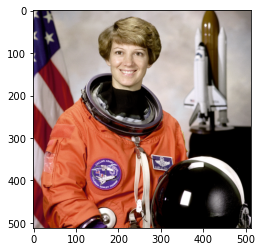

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(astro)

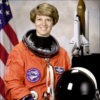

In [93]:
from IPython.display import Image
thumbnail(astro)
Image('thumb.png')

### Funkcije višeg reda

U Pythonu, funkcije su objekti kao i svi ostali; možemo ih normalno prenositi u funkcije i vraćati iz njih. Evo jedne funkcije koja stvara (vraća) linearnu funkciju s koeficijentom smjera $k$ i odsječkom na ordinati $l$.

In [62]:
def linearna(k, l):
    def funkcija(x): return k*x + l
    return funkcija

In [94]:
f = linearna(k=F(2,3), l=-1)
f(20)

Fraction(37, 3)

Često trebamo na određenom mjestu navesti neku funkciju zadanu pravilom preslikavanja, pa je nespretno pisati naredbu `def` i smišljati ime za nju. `lambda argumenti: izraz` je pokrata za

    def neka_funkcija(argumenti):
        return izraz
    neka_funkcija
    
i možemo je normalno koristiti u izrazima. Recimo, gornji kod smo mogli napisati i kao

    def linearna(k, l):
        return lambda x: k*x + l
        
ili čak kao

    linearna = lambda k, l: lambda x: k*x+l
    
ali ne treba pretjerivati. :-) Stilski vodič za Pythonovu standardnu biblioteku, [PEP8](https://www.python.org/dev/peps/pep-0008/) (koji mnogi shvaćaju i kao stilski vodič za Python općenito), preporučuje da se `lambda` koristi samo za anonimne funkcije: ako joj planiramo dati ime u trenutnom prostoru imena, bolje je funkciju definirati s `def`. Dakle, drugi isječak koda u ovoj ćeliji jest u skladu s PEP8, dok treći nije.

`lambda` se često koristi neopravdano: ako već postoji funkcija koja radi ono što želimo, nema nikakvog smisla stvoriti novu koja je samo poziva. Recimo, umjesto `lambda x: abs(x)` treba pisati jednostavno `abs`.

Evo funkcije koja komponira zadane funkcije (vraća njihovu kompoziciju). Zvjezdicom u `def f(*argumenti):` kažemo da funkcija može primati proizvoljni broj argumenata (ovdje funkcijâ koje treba komponirati). Naravno, sama kompozicija prima samo jedan argument $x$.

In [65]:
def komponiraj(*funkcije):
    def kompozicija(x):
        for f in reversed(funkcije): x = f(x)
        return x
    return kompozicija

Već smo vidjeli da Python koristi uvlačenje za istu svrhu za koju C koristi vitičaste zagrade. Tako je kôd puno čišći i lakši za čitanje. Kao i u C-u, ako se blok sastoji samo od jedne naredbe (gore `x = f(x)`), ne moramo ga uvući već ga možemo samo napisati u nastavku. Dvotočka je uvijek obavezna.

In [66]:
f = komponiraj(lambda x: x+1, lambda x: x*2, abs)

In [67]:
f(5)

11

Još jedna česta zloupotreba `lambda`-funkcijâ je kad imamo funkciju koja je _općenitija_ od one koja nama treba, odnosno želimo funkciju kojoj je prvih nekoliko argumenata (ili bilo kakvi argumenti specificirani imenima) fiksirano na neke vrijednosti. Tu je bolje koristiti `partial` iz biblioteke `functools`.

In [68]:
from functools import partial
dva_na = partial(pow, 2)

In [69]:
dva_na(12)

4096

In [70]:
komponiraj(dva_na, dva_na, f)

<function __main__.komponiraj.<locals>.kompozicija(x)>

In [71]:
_(1)

256

In [72]:
veliki_thumbnail = partial(thumbnail, širina=200, ime='veći.png')

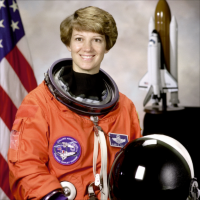

In [73]:
veliki_thumbnail(astro)
Image('veći.png')

## Kontrola toka

S `if...elif...else` pišemo grananja. `elif`ova može biti nula ili više, a i `else` je opcionalan. Uvjeti se provjeravajuuvjeti odozgo prema dolje dok se ne nađe neki koji je ispunjen, tada se izvrši odgovarajući blok i izvršavanje grananja je gotovo. Ako nijedan nije ispunjen i postoji `else`, izvršava se taj (zadnji) blok.

In [74]:
if 2 < 1: print('Nešto je čudno')
elif 2 == 1: print('Još čudnije')
elif 2 > 1: print('Sve ok')
else: print('Neusporedivi su?!')

Sve ok


Python podržava i ulančane usporedbe: `a < b < c < d` je kao `a < b and b < c and c < d`, osim što se izraz `b` izračuna samo jednom, a `c` jednom ili nijednom ovisno o tome je li `a < b`.

In [75]:
x = 1.8
if 2 <= x < 5: print(f'Broj {x} je između 2 i 5')
else: print(f'Broj {x} nije između 2 i 5')

Broj 1.8 nije između 2 i 5


U verziji 3.10 (možete je instalirati s `conda install -c conda-forge python=3.10`), Python je dobio i naredbu `match`, koja je slična (iako daleko moćnija) naredbi `switch` jezika C. Možete vidjeti kako se koristi u [PEP 636](https://www.python.org/dev/peps/pep-0636/).

```
    match mjesec:
        case 'veljače' if prijestupna(godina): zadnji_dan = 29
        case 'veljače': zadnji_dan = 28
        case 'travnja' | 'lipnja' | 'rujna' | 'studenoga': zadnji_dan = 30
        case _: zadnji_dan = 31
    assert 1 <= dan <= zadnji_dan
```

### Petlje

Petlja `for` nam omogućuje _iteraciju_: prolazak bilo kakvim spremnikom objekata (naravno, u slučaju skupova redoslijed nije specificiran): `for objekt in spremnik:`. Možemo i samo nabrojiti objekte po kojima prolazimo.

In [98]:
for riječ in 'Znanstvenici', 'vole', 'koristiti', 'Python':
    print(repr(riječ).rjust(20), 'ima', len(riječ), 'slova.')

      'Znanstvenici' ima 12 slova.
              'vole' ima 4 slova.
         'koristiti' ima 9 slova.
            'Python' ima 6 slova.


Uobičajene for-petlje u C-u su oblika `for (int i = a; i < b; i += c)` za neke $a$, $b$ i $c$. Pythonov objekt klase `range` je dizajniran tako da se isto može postići s `for i in range(a, b, c)`. Štoviše, podrazumijevane vrijednosti su `a=0` i `c=1`, tako da `for(i=0;i<n;++i)` možemo jednostavno napisati kao `for i in range(n)`.

In [96]:
for i in range(23, 95, 7): print(i)
# for (int i = 23; i < 95; i += 7)

23
30
37
44
51
58
65
72
79
86
93


Već smo vidjeli da s `f'...{izraz}...'` dobijemo string u koji su uklopljene (*interpolirane*) vrijednosti izraza u trenutku njegove evaluacije. U takvim stringovima, pomoću `{izraz:format}` možemo i formatirati vrijednosti u oblik u kojem želimo ispis. Za format se koriste [slične konvencije kao u C-u](https://docs.python.org/3/library/string.html#formatspec) (recimo `5.2f` za ispis realnog broja u polju širine 5, s dvije decimale), osim što umjesto negativnih širinâ za poravnanje stringova koristimo znakove `>` (desno), `^` (centrirano) ili `<` (lijevo).

In [78]:
parametri = dict(kamatna_stopa=0.07, točnost=2.879, iteracije=38)
for parametar, vrijednost in parametri.items():
    print(f'{parametar:>20} = {vrijednost:5.2f}')

       kamatna_stopa =  0.07
             točnost =  2.88
           iteracije = 38.00


`print` ima nekoliko parametara koji olakšavaju ispis: za `print(x,y,z)`, `sep` predstavlja string koji se ispisuje između `x` i `y` te između `y` i `z` (podrazumijevano `' '`), dok je `end` string koji se ispisuje nakon `z` (podrazumijevano `'\n'`, odnosno prelazak u novi red).

In [79]:
print(8, 7, 52, 4, sep='; zatim ', end='. I to je sve!')

8; zatim 7; zatim 52; zatim 4. I to je sve!

Petlje `while` koristimo jednako kao u C-u. Izvršavaju blok koda dok je ispunjen neki uvjet.

In [80]:
broj = 27
while broj > 1:
    if broj % 2: broj = broj*3 + 1
    else: broj //= 2
    print(broj, end='\t')

82	41	124	62	31	94	47	142	71	214	107	322	161	484	242	121	364	182	91	274	137	412	206	103	310	155	466	233	700	350	175	526	263	790	395	1186	593	1780	890	445	1336	668	334	167	502	251	754	377	1132	566	283	850	425	1276	638	319	958	479	1438	719	2158	1079	3238	1619	4858	2429	7288	3644	1822	911	2734	1367	4102	2051	6154	3077	9232	4616	2308	1154	577	1732	866	433	1300	650	325	976	488	244	122	61	184	92	46	23	70	35	106	53	160	80	40	20	10	5	16	8	4	2	1	

## Zadaci za vježbu

1. Napišite funkciju koja prima $n$, a vraća listu neparnih brojeva od $1$ do $n$.
2. Napišite funkciju koja rješava kvadratnu jednadžbu.
4. Napišite funkciju za numeričko deriviranje oblika `diff(f, x, h=1e-6)`.
3. Napišite funkciju `trapezint(f, n, a, b)` koja numerički računa integral funkcije $f$ na intervalu $[a,b]$, koristeći trapeznu formulu $$\int_a^b f(x)\,dx\approx\frac{h}{2}\sum_{i=1}^n{\bigl(f(x_{i-1})+f(x_i)\bigr)}.$$